# Exercise 2.2 - Random Matrix theory

In [1]:
from pathlib import Path

import numpy as np
import networkx as nx
import scipy.sparse
import matplotlib.pyplot as plt
import tqdm.contrib.concurrent

import disordered_sys.generate
import disordered_sys.methods

In [2]:
np.random.seed(42)
epsilon = 1e-3
c = 3
n = 2**11
lam = 0

figure_dir = Path.cwd() / ".." / "report" / "figures"
plt.rcParams['figure.dpi'] = 159
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['font.size'] = 18


m, g = disordered_sys.generate.generate_m(c, n, return_g=True)

### Implement cavity equation

In [3]:
def get_neighbors(g, k, j=-1):
    neighbors_set = set(g.neighbors(k)) - {j}
    return np.array(list(neighbors_set))

def cavity_equation(m, g, cav_precs, lam, k, j=-1):
    n_idxs = get_neighbors(g, k, j)
    n_weights = m[k, n_idxs]**2
    prec_weights = cav_precs[k, n_idxs].todense()

    return epsilon + 1j * lam + np.sum(n_weights / prec_weights)

### Initialize Marginal Cavity Precisions

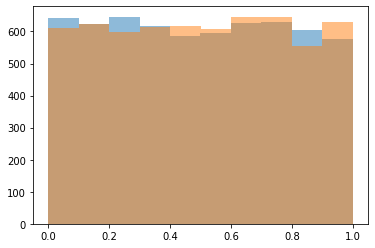

In [4]:
cavity_init = np.random.uniform(size=len(g.edges) * 2) + 1j * np.random.uniform(size=len(g.edges) * 2)
plt.hist(cavity_init.real, alpha=.5)
plt.hist(cavity_init.imag, alpha=.5)
plt.savefig(figure_dir / "ex2_cavity_init_hist.pdf")

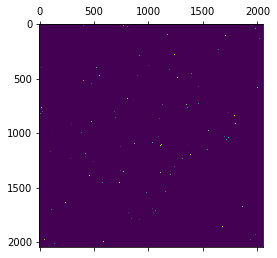

In [5]:
adj_mat = nx.to_scipy_sparse_array(g, nodelist=sorted(list(g.nodes())))
cavity_init = adj_mat[adj_mat.nonzero()] * cavity_init
cavity_precs = scipy.sparse.coo_matrix((cavity_init, adj_mat.nonzero()))
cavity_precs = cavity_precs.tocsr(copy=False)
plt.matshow(cavity_precs.todense().real)
plt.savefig(figure_dir / "ex2_cavity_init_mat.pdf")

In [6]:
def init_cavity_precs(g):
    cavity_init = np.random.uniform(size=len(g.edges) * 2) + 1j * np.random.uniform(size=len(g.edges) * 2)
    adj_mat = nx.to_scipy_sparse_array(g, nodelist=sorted(list(g.nodes())))
    cavity_init = adj_mat[adj_mat.nonzero()] * cavity_init
    cavity_precs = scipy.sparse.coo_matrix((cavity_init, adj_mat.nonzero()))
    cavity_precs = cavity_precs.tocsr(copy=False)
    return cavity_precs

### Run the Cavity method to obtain Marginal Cavity Precisions

In [7]:
tol = 1e-10
max_steps = 100

delta = np.inf
steps = 0
while delta > tol and steps < max_steps:
    reference = cavity_precs.copy()
    for k, j in g.to_directed().edges:
        cavity_precs[j, k] = cavity_equation(m, g, cavity_precs, lam, k, j)
    delta = np.max(np.abs(cavity_precs - reference))
    steps += 1
    print(f"{delta=:.4e} {steps=:e}", end="\r")

### Calculate the Marginal Precisions

In [8]:
marginals = np.mean(cavity_precs, axis=1)  # type: ignore

delta = np.inf
steps = 0
while delta > tol and steps < max_steps:
    reference = marginals.copy()
    for k in g.nodes:
        marginals[k] = cavity_equation(m, g, cavity_precs, lam, k)
    delta = np.max(np.abs(marginals - reference))
    steps += 1
    print(f"{delta=:.4e} {steps=:e}")

delta=1.4318e+03 steps=1.000000e+00
delta=0.0000e+00 steps=2.000000e+00


### Calculate the spectral density

In [9]:
G_ii = 1j / marginals
rho_lambda = G_ii.imag.mean() / np.pi
print(rho_lambda)

1.442220675720007


### Sweep over different $\lambda$

In [10]:
def spectral_density(lam):
    cavity_precs = init_cavity_precs(g)

    delta = np.inf
    steps = 0
    while delta > tol and steps < max_steps:
        reference = cavity_precs.copy()
        for k, j in g.to_directed().edges:
            cavity_precs[j, k] = cavity_equation(m, g, cavity_precs, lam, k, j)
        delta = np.max(np.abs(cavity_precs - reference))
        steps += 1


    marginals = np.mean(cavity_precs, axis=1)  # type: ignore

    delta = np.inf
    steps = 0
    while delta > tol and steps < max_steps:
        reference = marginals.copy()
        for k in g.nodes:
            marginals[k] = cavity_equation(m, g, cavity_precs, lam, k)
        delta = np.max(np.abs(marginals - reference))
        steps += 1
    
    G_ii = 1j / marginals
    rho_lambda = G_ii.imag.mean() / np.pi
    return rho_lambda

  0%|          | 0/50 [00:00<?, ?it/s]

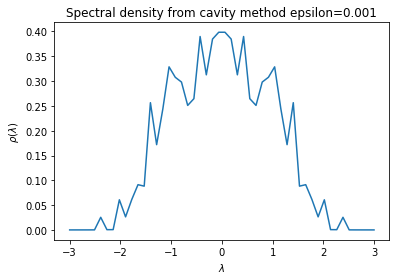

In [11]:
epsilon = 1e-3
lambdas = np.linspace(-3, 3, num=50)
spectrum = tqdm.contrib.concurrent.process_map(spectral_density, lambdas)
plt.plot(lambdas, spectrum)
plt.title(f"Spectral density from cavity method {epsilon=}")
plt.xlabel("$\\lambda$")
plt.ylabel("$\\rho(\\lambda)$")
plt.savefig(figure_dir / "ex2_spectrum_eps_large.pdf")

### Check behaviour for different $\varepsilon$

  0%|          | 0/50 [00:00<?, ?it/s]

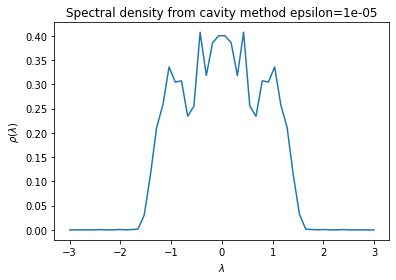

In [12]:
epsilon = 1e-5
lambdas = np.linspace(-3, 3, num=50)
spectrum = tqdm.contrib.concurrent.process_map(spectral_density, lambdas)
plt.plot(lambdas, spectrum)
plt.title(f"Spectral density from cavity method {epsilon=}")
plt.xlabel("$\\lambda$")
plt.ylabel("$\\rho(\\lambda)$")
plt.savefig(figure_dir / "ex2_spectrum_eps_medium.pdf")

  0%|          | 0/50 [00:00<?, ?it/s]

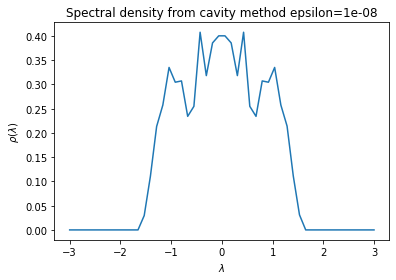

In [13]:
epsilon = 1e-8
lambdas = np.linspace(-3, 3, num=50)
spectrum = tqdm.contrib.concurrent.process_map(spectral_density, lambdas)
plt.plot(lambdas, spectrum)
plt.title(f"Spectral density from cavity method {epsilon=}")
plt.xlabel("$\\lambda$")
plt.ylabel("$\\rho(\\lambda)$")
plt.savefig(figure_dir / "ex2_spectrum_eps_small.pdf")